# Model Building using Tensorflow CPU


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump,load
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time
import GPUtil
import psutil


In [2]:
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # ✅ also force cudnn kernels to deterministic
os.environ['CUDNN_VISIBLE_DEVICES'] = '-1'  # ✅ also force cudnn kernels to deterministic

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
df = pd.read_csv(r"../data/simulated_train.csv")


In [4]:


def smart_fill_temp(series):
    series = series.copy()
    for idx in series[series.isna()].index:
        # Look forward to next 2 valid values
        next_vals = series[idx+1:idx+10].dropna().values[:2]
        if len(next_vals) > 0:
            avg_val = round(np.mean(next_vals))
            series.loc[idx] = avg_val
    return series

df['TEMP_30MIN_AGO'] = smart_fill_temp(df['TEMP_30MIN_AGO'].astype(float))

df['IRR_15MIN_AGO']= df['IRR_15MIN_AGO'].fillna(0.0)

## MLP Baseline model

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,ReLU
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf


In [6]:
df_mlp = df.copy()

In [7]:
df_mlp= df_mlp.drop(columns=['DATE_TIME','HOUR','MINUTE'])

In [8]:
df_mlp.columns

Index(['AMBIENT_TEMPERATURE', 'IRRADIATION', 'DC_POWER', 'HOUR_SIN',
       'HOUR_COS', 'IS_NIGHT', 'DAWN_DUSK', 'DC_PER_IRR', 'IRR_15MIN_AGO',
       'TEMP_30MIN_AGO', 'DAY_OF_WEEK', 'IS_WEEKEND'],
      dtype='object')

In [9]:
features = ['AMBIENT_TEMPERATURE', 'IRRADIATION', 'DC_PER_IRR',
       'HOUR_SIN', 'HOUR_COS', 'IS_NIGHT', 'DAWN_DUSK', 
       'IRR_15MIN_AGO', 'TEMP_30MIN_AGO', 'DAY_OF_WEEK', 'IS_WEEKEND']
target = ['DC_POWER']
scale = ['AMBIENT_TEMPERATURE', 'IRRADIATION', 'DC_PER_IRR','IRR_15MIN_AGO', 'TEMP_30MIN_AGO']

In [10]:
X_to_scale = df_mlp[scale]
X_rest = df_mlp[[col for col in features if col not in scale]]

scaler_x = MinMaxScaler()
X_scaled = pd.DataFrame(scaler_x.fit_transform(X_to_scale), columns=scale, index=df_mlp.index)

X = pd.concat([X_scaled, X_rest], axis=1)[features]

In [11]:
dump(scaler_x,'../model/mlp_x_scaler_cpu.joblib')

['../model/mlp_x_scaler_cpu.joblib']

In [12]:
y = df_mlp[target]

scaler_y = MinMaxScaler()
y_scaled = pd.DataFrame(scaler_y.fit_transform(y),columns=target,index=df_mlp.index)
y = y_scaled

In [13]:
dump(scaler_y,'../model/mlp_y_scaler_cpu.joblib')

['../model/mlp_y_scaler_cpu.joblib']

In [14]:
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

In [15]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam',loss='mae',metrics=['mse'])

In [16]:
class TimeResourceCallback(tf.keras.callbacks.Callback):
    def __init__(self, device="cpu"):
        super().__init__()
        self.device = device.lower()

    def on_train_begin(self, logs=None):
        self.epoch_times = []
        self.gpu_memory = []
        self.cpu_memory = []

    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        # record time
        self.epoch_times.append(time.time() - self.start_time)

        if self.device == "gpu" and tf.config.list_physical_devices('GPU'):
            # check GPU usage
            gpus = GPUtil.getGPUs()
            if gpus:
                self.gpu_memory.append(gpus[0].memoryUsed)  # in MB
                self.cpu_memory.append(None)
            else:
                self.gpu_memory.append(0.0)
                self.cpu_memory.append(None)
        else:
            # CPU mode → log system RAM
            mem = psutil.virtual_memory().used / (1024 ** 2)  # MB
            self.cpu_memory.append(mem)
            self.gpu_memory.append(None)


In [17]:

# early_stop = EarlyStopping(patience=2,verbose=1),callbacks=[early_stop]
start = time.time()
time_res_cb = TimeResourceCallback()
history = model.fit(X_train,y_train,validation_data=(X_val, y_val),epochs=100,batch_size=64,shuffle=True,callbacks=[time_res_cb],verbose=1)
end = time.time()
train_time = end - start

Epoch 1/100
6/6 [==============================] - 2s 55ms/step - loss: 0.2304 - mse: 0.1195 - val_loss: 0.1404 - val_mse: 0.0453
Epoch 2/100
6/6 [==============================] - 0s 13ms/step - loss: 0.1420 - mse: 0.0468 - val_loss: 0.0922 - val_mse: 0.0167
Epoch 3/100
6/6 [==============================] - 0s 12ms/step - loss: 0.0851 - mse: 0.0144 - val_loss: 0.0996 - val_mse: 0.0214
Epoch 4/100
6/6 [==============================] - 0s 12ms/step - loss: 0.0634 - mse: 0.0080 - val_loss: 0.0696 - val_mse: 0.0075
Epoch 5/100
6/6 [==============================] - 0s 12ms/step - loss: 0.0477 - mse: 0.0046 - val_loss: 0.0482 - val_mse: 0.0045
Epoch 6/100
6/6 [==============================] - 0s 12ms/step - loss: 0.0342 - mse: 0.0024 - val_loss: 0.0474 - val_mse: 0.0049
Epoch 7/100
6/6 [==============================] - 0s 12ms/step - loss: 0.0242 - mse: 0.0011 - val_loss: 0.0556 - val_mse: 0.0054
Epoch 8/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0223 - mse: 8.15

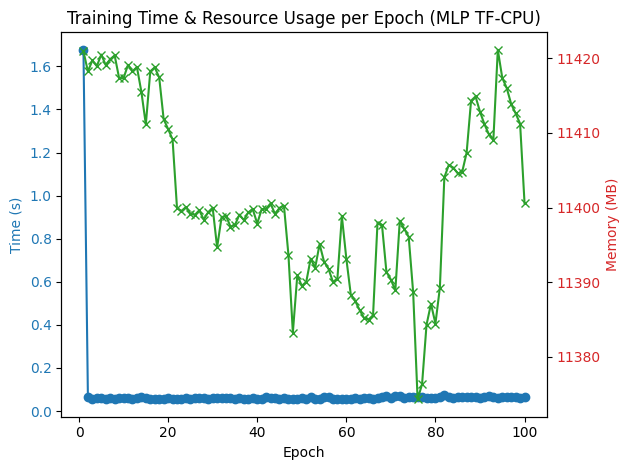

In [18]:
epochs = range(1, len(time_res_cb.epoch_times) + 1)

fig, ax1 = plt.subplots()

# Epoch time
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Time (s)', color='tab:blue')
ax1.plot(epochs, time_res_cb.epoch_times, color='tab:blue', marker='o', label="Time per epoch")
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Resource usage
ax2 = ax1.twinx()
ax2.set_ylabel('Memory (MB)', color='tab:red')

if any(time_res_cb.gpu_memory):
    ax2.plot(epochs, time_res_cb.gpu_memory, color='tab:red', marker='x', label="GPU Memory")
else:
    ax2.plot(epochs, time_res_cb.cpu_memory, color='tab:green', marker='x', label="CPU Memory")

ax2.tick_params(axis='y', labelcolor='tab:red')
plt.title("Training Time & Resource Usage per Epoch (MLP TF-CPU)")
fig.tight_layout()
plt.show()

In [19]:

y_pred_scaled = np.clip(model.predict(X_val), 0, None) 
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_val_inv = scaler_y.inverse_transform(y_val)


print(f"MAE: {mean_absolute_error(y_val_inv, y_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_val_inv, y_pred)):.4f}")
print(f"R²: {r2_score(y_val_inv, y_pred):.4f}")
print(f"Training time: {train_time:.2f} seconds")

3/3 [==============================] - 0s 2ms/step
MAE: 0.4218
RMSE: 0.5953
R²: 0.9925
Training time: 9.13 seconds


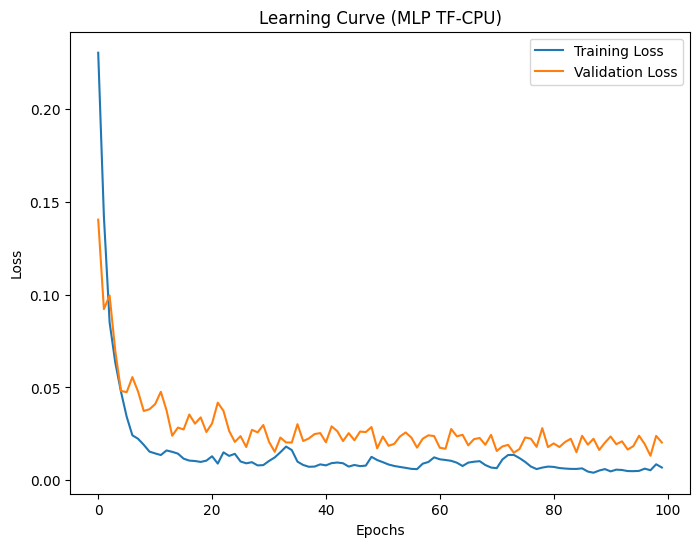

In [20]:
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve (MLP TF-CPU)')
plt.legend()
plt.show()

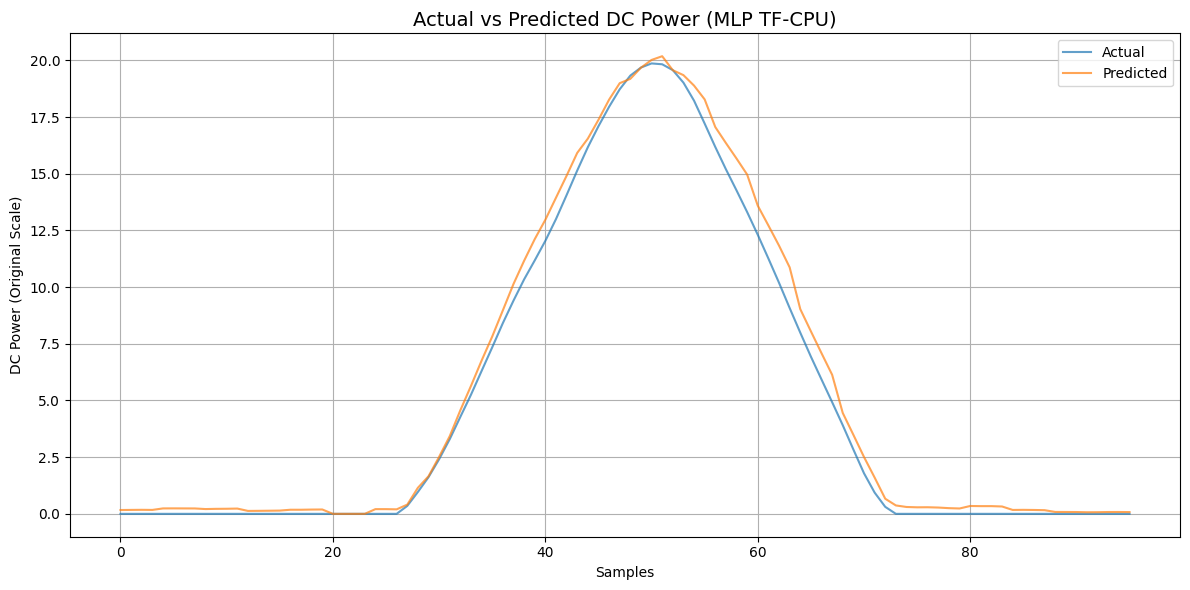

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(y_val_inv, label='Actual', alpha=0.7)
plt.plot(y_pred, label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted DC Power (MLP TF-CPU)', fontsize=14)
plt.xlabel('Samples')
plt.ylabel('DC Power (Original Scale)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

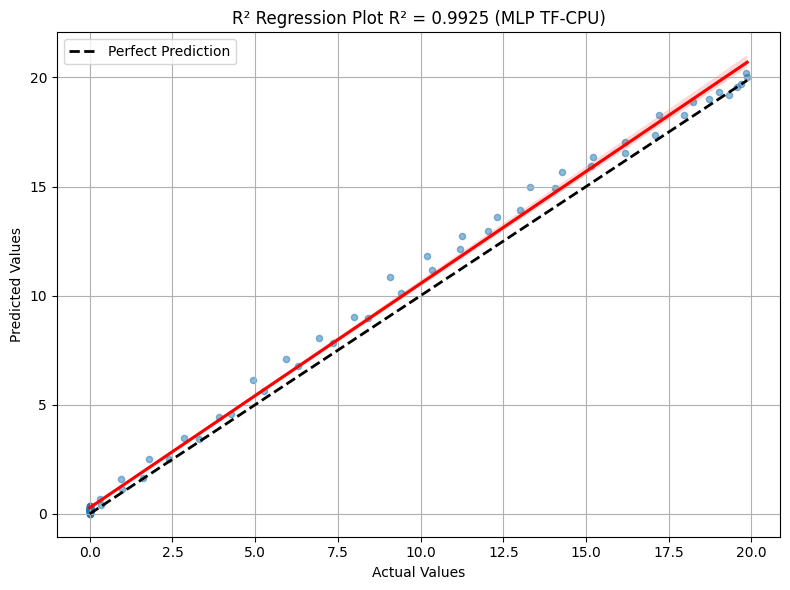

In [22]:
r2 = r2_score(y_val_inv, y_pred)

plt.figure(figsize=(8, 6))
sns.regplot(x=y_val_inv.flatten(), y=y_pred.flatten(), scatter_kws={"alpha":0.5, "s": 20}, line_kws={"color":"red"})
plt.plot([y_val_inv.min(), y_val_inv.max()], [y_val_inv.min(), y_val_inv.max()], 'k--', lw=2, label='Perfect Prediction')

plt.title(f'R² Regression Plot R² = {r2:.4f} (MLP TF-CPU)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
model.save(r'../model/MLP_base_model_cpu.keras')




In [24]:

date_time = df.loc[y_val.index,'DATE_TIME']  


df_forecast = pd.DataFrame({
    "DATE_TIME": date_time,
    "Actual": y_val_inv.flatten(),
    "Predicted": y_pred.flatten()
})


df_forecast["DATE_TIME"] = pd.to_datetime(df_forecast["DATE_TIME"])


mask = (df_forecast["DATE_TIME"].dt.time >= pd.to_datetime("07:00").time()) & \
       (df_forecast["DATE_TIME"].dt.time <= pd.to_datetime("14:00").time())

df_8hr = df_forecast[mask]
df_hourly = df_forecast.iloc[::4]  





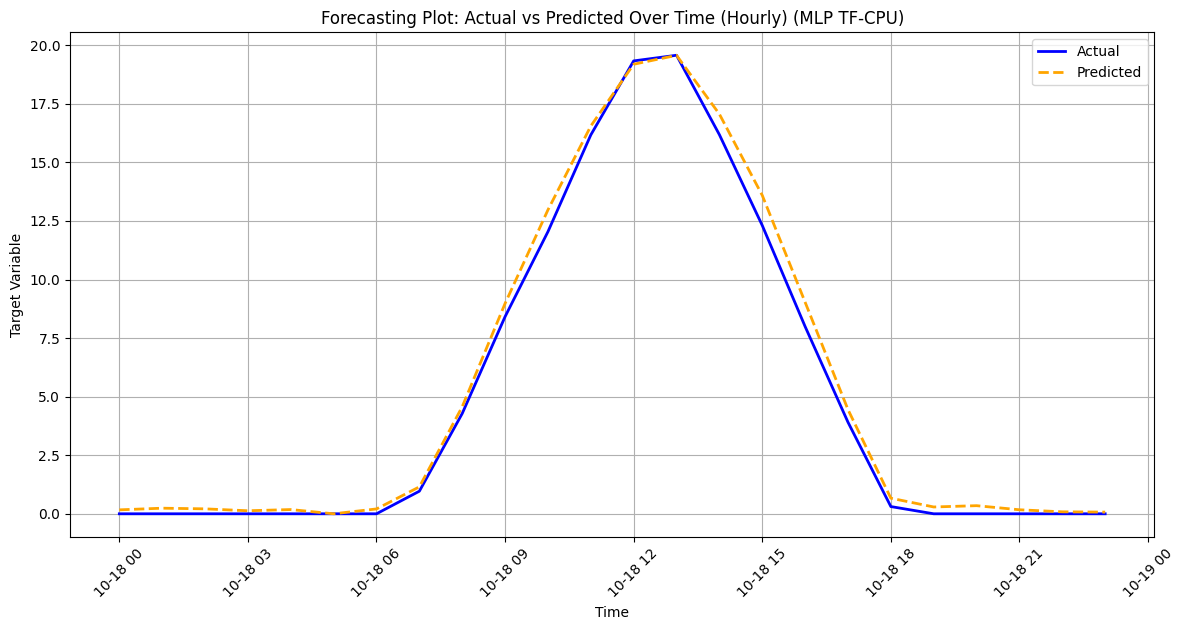

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(df_hourly["DATE_TIME"], df_hourly["Actual"], label="Actual", color="blue", linewidth=2)
plt.plot(df_hourly["DATE_TIME"], df_hourly["Predicted"], label="Predicted", color="orange", linestyle="--", linewidth=2)

plt.title("Forecasting Plot: Actual vs Predicted Over Time (Hourly) (MLP TF-CPU)")
plt.xlabel("Time")
plt.ylabel("Target Variable")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


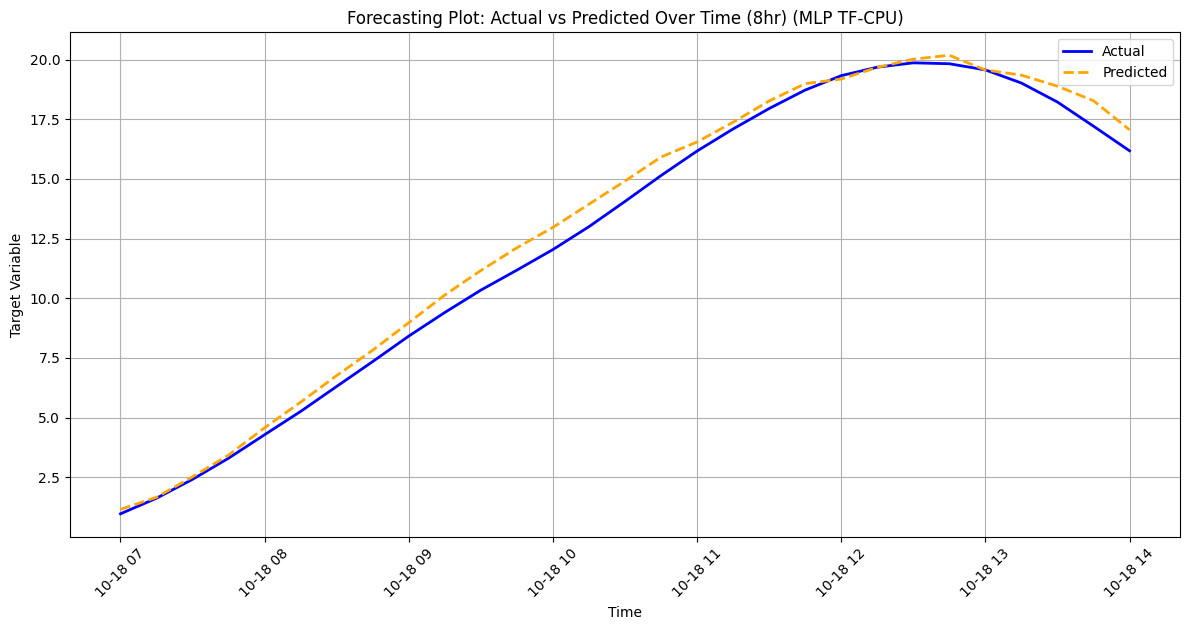

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(df_8hr["DATE_TIME"], df_8hr["Actual"], label="Actual", color="blue", linewidth=2)
plt.plot(df_8hr["DATE_TIME"], df_8hr["Predicted"], label="Predicted", color="orange", linestyle="--", linewidth=2)

plt.title("Forecasting Plot: Actual vs Predicted Over Time (8hr) (MLP TF-CPU)")
plt.xlabel("Time")
plt.ylabel("Target Variable")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


## LSTM

In [27]:


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout,LayerNormalization,LeakyReLU
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error



In [28]:
df_lstm = df.copy()

In [29]:


features = ['AMBIENT_TEMPERATURE', 'IRRADIATION', 'DC_PER_IRR',
       'HOUR_SIN', 'HOUR_COS', 'IS_NIGHT', 'DAWN_DUSK', 
       'IRR_15MIN_AGO', 'TEMP_30MIN_AGO', 'DAY_OF_WEEK', 'IS_WEEKEND']
target = ['DC_POWER']
scale = ['AMBIENT_TEMPERATURE', 'IRRADIATION', 'DC_PER_IRR','IRR_15MIN_AGO', 'TEMP_30MIN_AGO']



In [30]:
X_to_scale = df_lstm[scale]
X_rest = df_lstm[[col for col in features if col not in scale]]

scaler_x = MinMaxScaler()
X_scaled = pd.DataFrame(scaler_x.fit_transform(X_to_scale), columns=scale, index=df_lstm.index)

X = pd.concat([X_scaled, X_rest], axis=1)[features]

In [31]:
y = df_lstm[target]

scaler_y = MinMaxScaler()
y_scaled = pd.DataFrame(scaler_y.fit_transform(y),columns=target,index=df_lstm.index)
y = y_scaled

In [32]:
dump(scaler_x,r'../model/lstm_x_scaler_cpu.joblib')
dump(scaler_y,r'../model/lstm_y_scaler_cpu.joblib')

['../model/lstm_y_scaler_cpu.joblib']

In [33]:
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

In [34]:
y_train = y_train.to_numpy().reshape(-1, 1)
y_val = y_val.to_numpy().reshape(-1, 1)
X_train = X_train.to_numpy().reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.to_numpy().reshape((X_val.shape[0], 1, X_val.shape[1]))

In [35]:
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(1, X_train.shape[2]),
          kernel_regularizer=regularizers.L2(0.01)),
    LSTM(64, return_sequences=False),
    Dense(64),
    LeakyReLU(alpha=0.1),
    Dense(32),
    LeakyReLU(alpha=0.1),
    Dense(1)
])
model.compile(optimizer='adam', loss='mae', metrics=['mse'])


In [36]:
class TimeResourceCallback(tf.keras.callbacks.Callback):
    def __init__(self, device="cpu"):
        super().__init__()
        self.device = device.lower()

    def on_train_begin(self, logs=None):
        self.epoch_times = []
        self.gpu_memory = []
        self.cpu_memory = []

    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        # record time
        self.epoch_times.append(time.time() - self.start_time)

        if self.device == "gpu" and tf.config.list_physical_devices('GPU'):
            # check GPU usage
            gpus = GPUtil.getGPUs()
            if gpus:
                self.gpu_memory.append(gpus[0].memoryUsed)  # in MB
                self.cpu_memory.append(None)
            else:
                self.gpu_memory.append(0.0)
                self.cpu_memory.append(None)
        else:
            # CPU mode → log system RAM
            mem = psutil.virtual_memory().used / (1024 ** 2)  # MB
            self.cpu_memory.append(mem)
            self.gpu_memory.append(None)


In [37]:
start = time.time()
time_res_cb = TimeResourceCallback()
history = model.fit(X_train,y_train,validation_data=(X_val, y_val),epochs=100,batch_size=64,shuffle=True,callbacks=[time_res_cb],verbose=1)
end = time.time()
train_time = end - start

Epoch 1/100
6/6 [==============================] - 7s 326ms/step - loss: 0.4586 - mse: 0.1828 - val_loss: 0.4092 - val_mse: 0.1481
Epoch 2/100
6/6 [==============================] - 0s 19ms/step - loss: 0.4137 - mse: 0.1634 - val_loss: 0.3643 - val_mse: 0.1305
Epoch 3/100
6/6 [==============================] - 0s 18ms/step - loss: 0.3669 - mse: 0.1426 - val_loss: 0.3148 - val_mse: 0.1031
Epoch 4/100
6/6 [==============================] - 0s 19ms/step - loss: 0.3139 - mse: 0.1047 - val_loss: 0.2548 - val_mse: 0.0630
Epoch 5/100
6/6 [==============================] - 0s 20ms/step - loss: 0.2433 - mse: 0.0553 - val_loss: 0.1889 - val_mse: 0.0202
Epoch 6/100
6/6 [==============================] - 0s 19ms/step - loss: 0.1742 - mse: 0.0167 - val_loss: 0.1600 - val_mse: 0.0127
Epoch 7/100
6/6 [==============================] - 0s 19ms/step - loss: 0.1359 - mse: 0.0076 - val_loss: 0.1152 - val_mse: 0.0045
Epoch 8/100
6/6 [==============================] - 0s 19ms/step - loss: 0.1135 - mse: 0.0

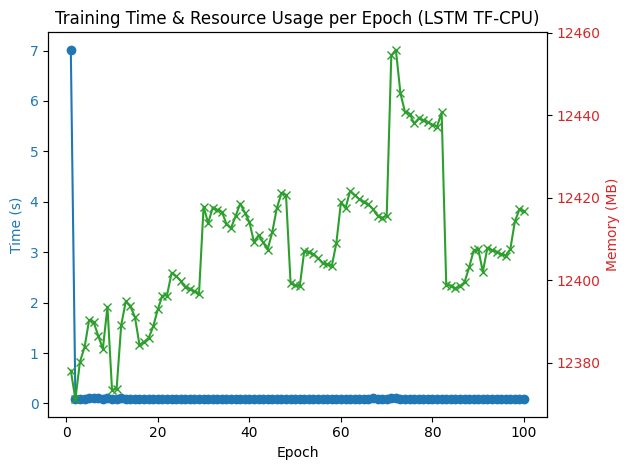

In [38]:
epochs = range(1, len(time_res_cb.epoch_times) + 1)

fig, ax1 = plt.subplots()

# Epoch time
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Time (s)', color='tab:blue')
ax1.plot(epochs, time_res_cb.epoch_times, color='tab:blue', marker='o', label="Time per epoch")
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Resource usage
ax2 = ax1.twinx()
ax2.set_ylabel('Memory (MB)', color='tab:red')

if any(time_res_cb.gpu_memory):
    ax2.plot(epochs, time_res_cb.gpu_memory, color='tab:red', marker='x', label="GPU Memory")
else:
    ax2.plot(epochs, time_res_cb.cpu_memory, color='tab:green', marker='x', label="CPU Memory")

ax2.tick_params(axis='y', labelcolor='tab:red')
plt.title("Training Time & Resource Usage per Epoch (LSTM TF-CPU)")
fig.tight_layout()
plt.show()

In [39]:
y_pred_scaled = np.clip(model.predict(X_val), 0, None) 
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_val_inv = scaler_y.inverse_transform(y_val)


print(f"MAE: {mean_absolute_error(y_val_inv, y_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_val_inv, y_pred)):.4f}")
print(f"R²: {r2_score(y_val_inv, y_pred):.4f}")
print(f"Training time: {train_time:.2f} seconds")

3/3 [==============================] - 1s 5ms/step
MAE: 0.2269
RMSE: 0.3805
R²: 0.9969
Training time: 17.22 seconds


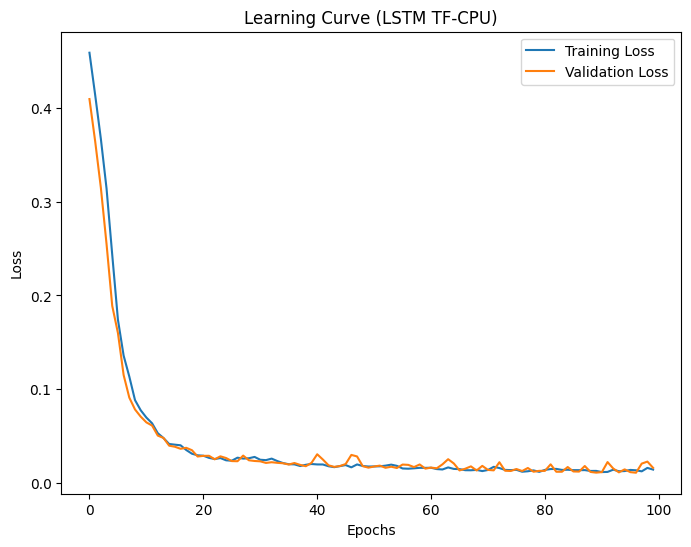

In [40]:
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve (LSTM TF-CPU)')
plt.legend()
plt.show()

In [41]:


model.save(r'../model/LSTM_model_cpu.keras')

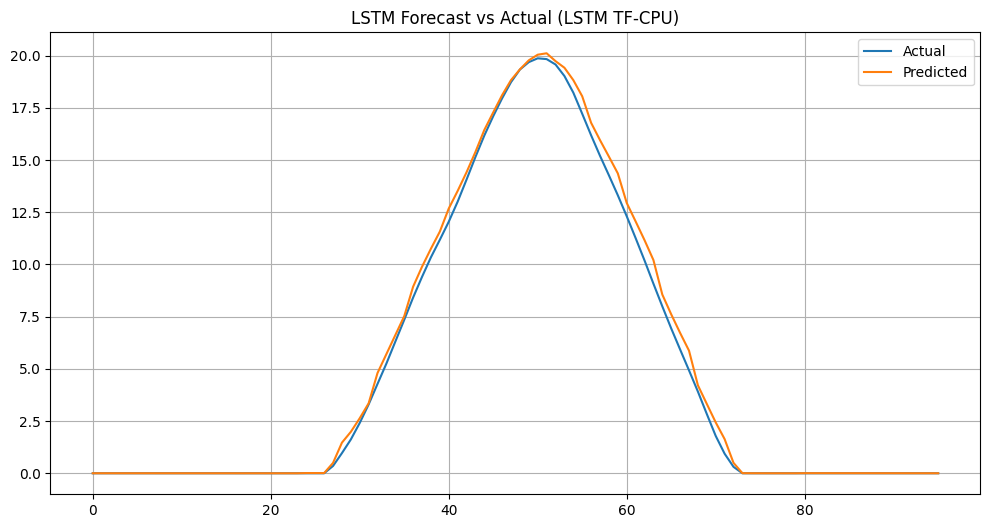

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_val_inv, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title("LSTM Forecast vs Actual (LSTM TF-CPU)")
plt.legend()
plt.grid(True)
plt.show()


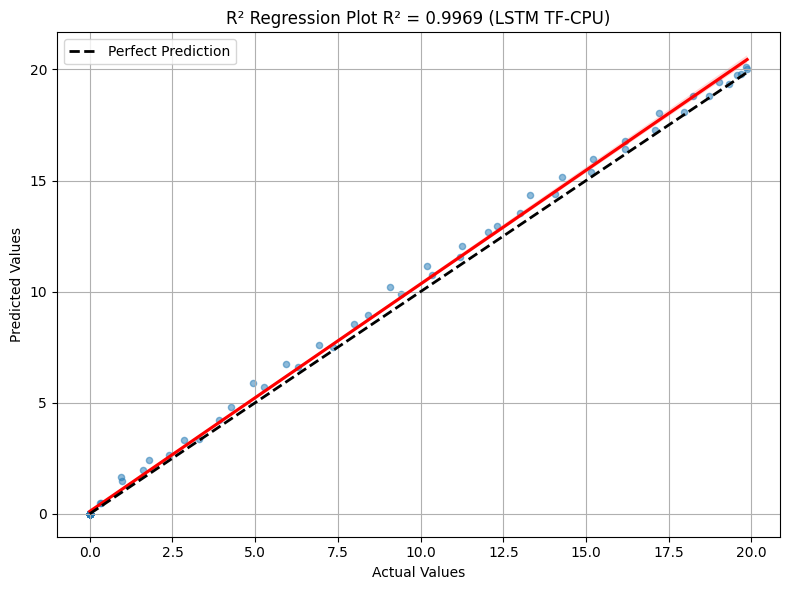

In [43]:
r2 = r2_score(y_val_inv, y_pred)

plt.figure(figsize=(8, 6))
sns.regplot(x=y_val_inv.flatten(), y=y_pred.flatten(), scatter_kws={"alpha":0.5, "s": 20}, line_kws={"color":"red"})
plt.plot([y_val_inv.min(), y_val_inv.max()], [y_val_inv.min(), y_val_inv.max()], 'k--', lw=2, label='Perfect Prediction')

plt.title(f'R² Regression Plot R² = {r2:.4f} (LSTM TF-CPU)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [44]:
# Extract DATE_TIME column before converting to numpy
date_time = df["DATE_TIME"]

# Manual split
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]
dt_train, dt_val = date_time[:train_size], date_time[train_size:]

# Convert to NumPy arrays
y_train = y_train.to_numpy().reshape(-1, 1)
y_val = y_val.to_numpy().reshape(-1, 1)
X_train = X_train.to_numpy().reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.to_numpy().reshape((X_val.shape[0], 1, X_val.shape[1]))
  


df_forecast = pd.DataFrame({
    "DATE_TIME": dt_val.reset_index(drop=True),
    "Actual": y_val_inv.flatten(),
    "Predicted": y_pred.flatten()
})

df_forecast["DATE_TIME"] = pd.to_datetime(df_forecast["DATE_TIME"])  

mask = (df_forecast["DATE_TIME"].dt.time >= pd.to_datetime("07:00").time()) & \
       (df_forecast["DATE_TIME"].dt.time <= pd.to_datetime("14:00").time())

df_8hr = df_forecast[mask]
df_hourly = df_forecast.iloc[::4]  





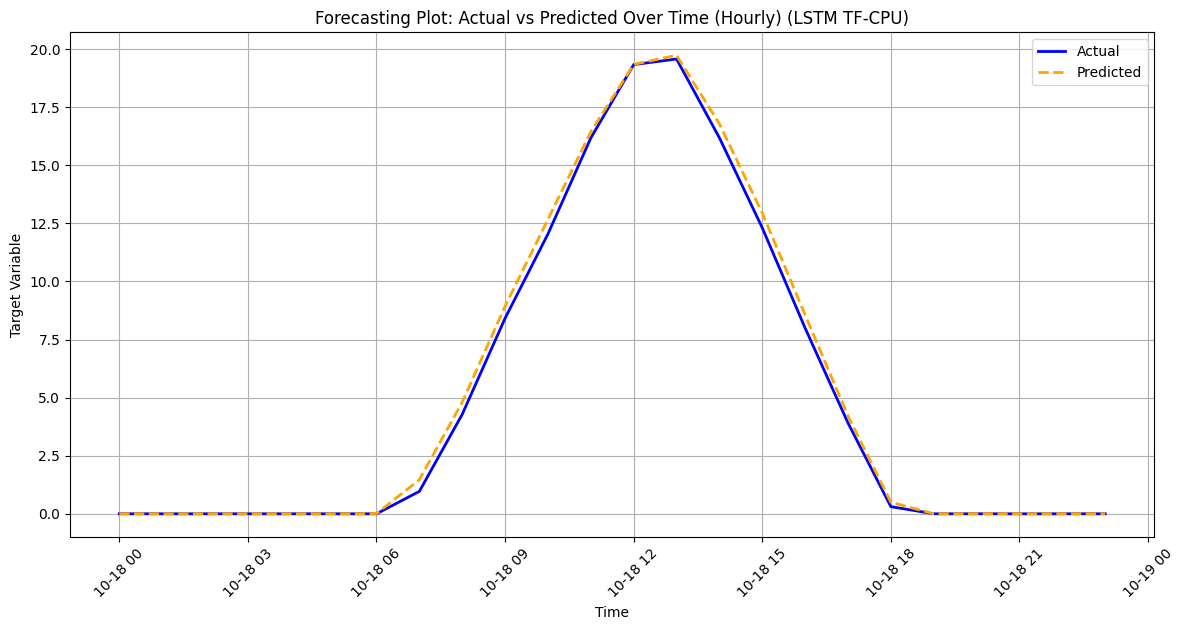

In [45]:
plt.figure(figsize=(12, 6))
plt.plot(df_hourly["DATE_TIME"], df_hourly["Actual"], label="Actual", color="blue", linewidth=2)
plt.plot(df_hourly["DATE_TIME"], df_hourly["Predicted"], label="Predicted", color="orange", linestyle="--", linewidth=2)

plt.title("Forecasting Plot: Actual vs Predicted Over Time (Hourly) (LSTM TF-CPU)")
plt.xlabel("Time")
plt.ylabel("Target Variable")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


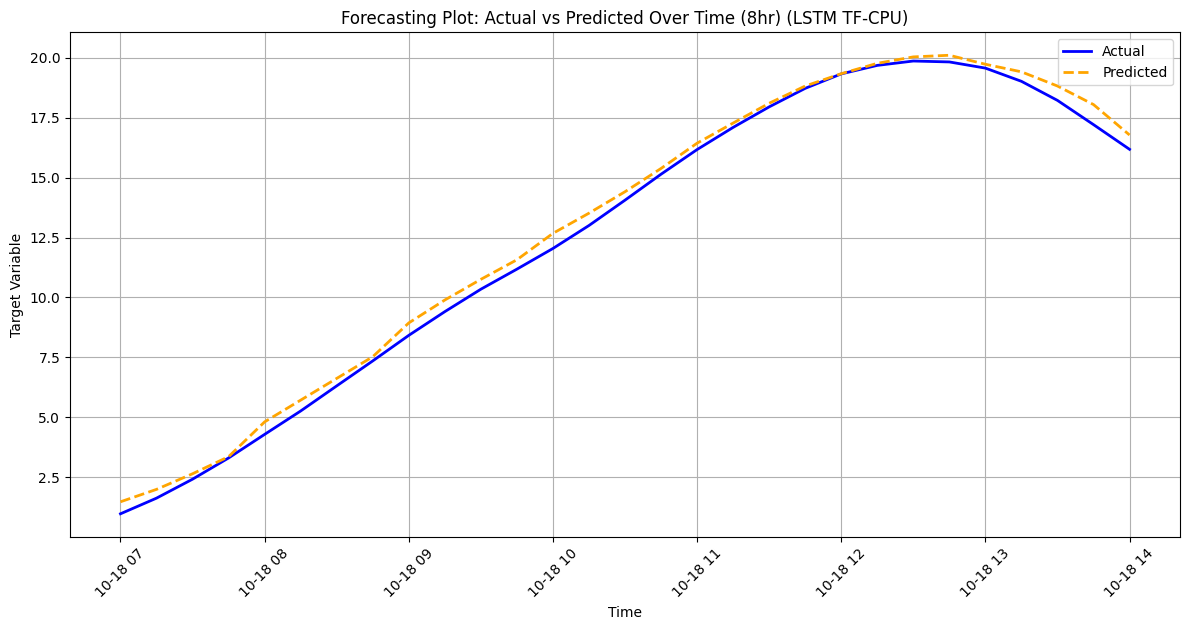

In [46]:
plt.figure(figsize=(12, 6))
plt.plot(df_8hr["DATE_TIME"], df_8hr["Actual"], label="Actual", color="blue", linewidth=2)
plt.plot(df_8hr["DATE_TIME"], df_8hr["Predicted"], label="Predicted", color="orange", linestyle="--", linewidth=2)

plt.title("Forecasting Plot: Actual vs Predicted Over Time (8hr) (LSTM TF-CPU)")
plt.xlabel("Time")
plt.ylabel("Target Variable")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()
